# MNIST classification + OOP

In this task, it need to use a publicly available simple MNIST dataset and build 3 classification models around it. It should be the following models:
1) Random Forest;
2) Feed-Forward Neural Network;
3) Convolutional Neural Network.

**Tools**

In [ ]:
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib
import io
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

**`MnistClassifierInterface` class**

Each model should be a separate class that implements `MnistClassifierInterface` with 2 abstract methods - `train` and `predict`.

In [124]:
class MnistClassifierInterface(ABC):
    def __init__(self, image_shape=(28, 28)):
        self.image_shape = image_shape
        
    @abstractmethod
    def train(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X_test):
        pass

**Random Forest class**

In [125]:
class RandomForestModel(MnistClassifierInterface):
    def __init__(self):
        super().__init__()
        self.model = RandomForestClassifier()
        self.image_size = self.image_shape[0] * self.image_shape[1]  # 784

    def train(self, X_train, y_train):
        n_images_train = X_train.shape[0]  # 60 000
        X_train = X_train.reshape(n_images_train, self.image_size)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        n_images_test = X_test.shape[0]  # 10 000
        X_test = X_test.reshape(n_images_test, self.image_size)
        return self.model.predict(X_test)

**Feed-Forward Neural Network class**

In [126]:
class NeuralNetworkModel(MnistClassifierInterface):
    def __init__(self):
        super().__init__()
        self.model = keras.Sequential(
            [
                keras.layers.Input(shape=self.image_shape),
                keras.layers.Flatten(),  # converts 28x28 to 784
                keras.layers.Dense(512, activation="relu"),
                keras.layers.Dense(128, activation="relu"),
                keras.layers.Dense(10, activation="softmax"),
            ]
        )
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self, X_train, y_train):
        X_train = X_train / 255.0
        early_stop = EarlyStopping(
            monitor="accuracy", patience=5, restore_best_weights=True
        )
        self.model.fit(
            X_train, y_train, epochs=15, batch_size=128, callbacks=[early_stop], verbose=1
        )

    def predict(self, X_test):
        X_test = X_test / 255.0
        return self.model.predict(X_test).argmax(
            axis=1
        )  # Selects the class (index) with the highest probability for each sample.

**Convolutional Neural Network class**

In [127]:
class CNNModel(MnistClassifierInterface):
    def __init__(self):
        super().__init__()
        self.model = keras.Sequential(
            [
                keras.layers.Input(shape=(self.image_shape[0], self.image_shape[1], 1)),
                keras.layers.Conv2D(32, (3, 3), activation="relu"),
                keras.layers.MaxPooling2D(2, 2),
                keras.layers.Conv2D(64, (3, 3), activation="relu"),
                keras.layers.MaxPooling2D(2, 2),
                keras.layers.Flatten(),  # converts 28x28 to 784
                keras.layers.Dense(512, activation="relu"),
                keras.layers.Dense(128, activation="relu"),
                keras.layers.Dense(10, activation="softmax"),
            ]
        )

        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self, X_train, y_train):
        X_train = X_train / 255.0
        early_stop = EarlyStopping(
            monitor="accuracy", patience=5, restore_best_weights=True
        )
        self.model.fit(
            X_train,
            y_train,
            epochs=15,
            batch_size=128,
            callbacks=[early_stop],
            verbose=1,
        )

    def predict(self, X_test):
        X_test = X_test / 255.0
        return self.model.predict(X_test).argmax(
            axis=1
        )  # Selects the class (index) with the highest probability for each sample.

**`MnistClassifier` class**

Each of three models should be hidden under another `MnistClassifier` class. `MnistClassifer` takes an algorithm as an input parameter. Possible values for the algorithm are: `cnn`, `rf`, and `nn` for the three models described above.

In [128]:
class MnistClassifier:
    def __init__(self, algorithm):
        if algorithm == "rf":
            self.classifier = RandomForestModel()
        elif algorithm == "nn":
            self.classifier = NeuralNetworkModel()
        elif algorithm == "cnn":
            self.classifier = CNNModel()
        else:
            raise ValueError("Invalid algorithm. Choose from: 'rf', 'nn', 'cnn'.")

    def train(self, X_train, y_train):
        self.classifier.train(X_train, y_train)

    def predict(self, X_test):
        return self.classifier.predict(X_test)

## Examples

**Model training and prediction function**

In [129]:
def model_training_prediction(model, X_train, y_train, X_test, y_test):
    # Training
    model.train(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)
    print(
        f"Classification report for the model:\n",
        classification_report(y_test, y_pred),
    )

**Visualization of the prediction function**

In [130]:
def plot_predictions(X_test, y_test, y_pred, n_images=10):
    plt.figure(figsize=(10, 7))
    for i in range(n_images):
        plt.subplot(n_images // 5 + 1, 5, i + 1)
        plt.imshow(X_test[i], cmap="gray")  # Відображаємо зображення
        plt.title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}")
        plt.axis("off")

    plt.show()

**Model size evaluation function**

In [131]:
def model_size_evaluation(model):
    # Creating an in-memory buffer
    buffer = io.BytesIO()

    # Saving the model to the buffer
    joblib.dump(model, buffer)

    # Estimating the model size in bytes
    size_in_bytes = buffer.tell()
    size_in_kb = size_in_bytes / 1024
    size_in_mb = size_in_kb / 1024
    print(
        f"Model size in memory: {size_in_bytes} B ({size_in_kb:.2f} kB / {size_in_mb:.2f} MB)"
    )

**Importing dataset MNIST**

In [132]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Model Random Forest

In [133]:
model_rf = MnistClassifier(algorithm="rf")

In [134]:
# Training
model_rf.train(X_train, y_train)

In [135]:
# Prediction
y_pred_rf = model_rf.predict(X_test)
print(
    f"Classification report for the model:\n",
    classification_report(y_test, y_pred_rf),
)

Classification report for the model:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [136]:
# Size evaluation
model_size_evaluation(model_rf)

Model size in memory: 144188189 B (140808.78 kB / 137.51 MB)


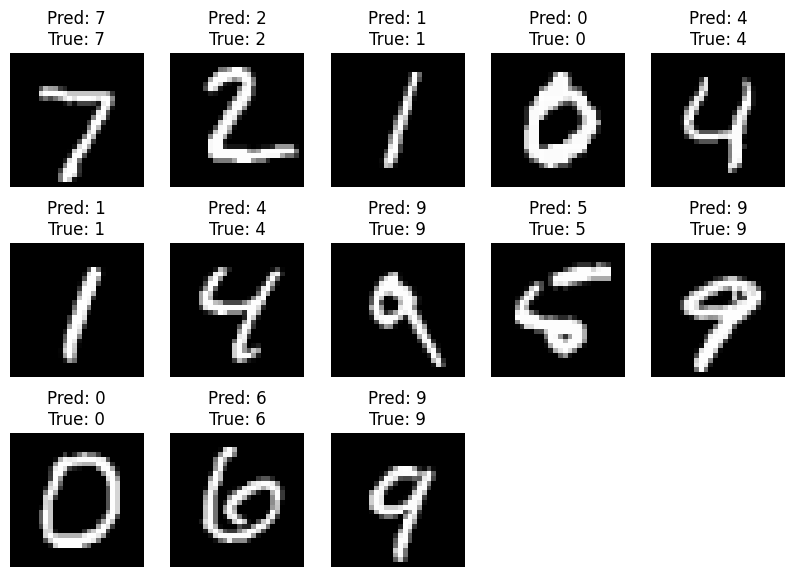

In [137]:
plot_predictions(X_test, y_test, y_pred_rf, n_images=13)

### Model Feed-Forward Neural Network

In [138]:
model_nn = MnistClassifier(algorithm="nn")

In [139]:
# Training
model_nn.train(X_train, y_train)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8761 - loss: 0.4279
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9738 - loss: 0.0901
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9844 - loss: 0.0541
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9903 - loss: 0.0340
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9909 - loss: 0.0282
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9943 - loss: 0.0188
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9930 - loss: 0.0212
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9961 - loss: 0.0129
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9956 - loss: 0.0125
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9964 - loss: 0.0118
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9966 - loss: 0.0097
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

In [140]:
# Prediction
y_pred_nn = model_nn.predict(X_test)
print(
    f"Classification report for the model:\n",
    classification_report(y_test, y_pred_nn),
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification report for the model:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [141]:
# Size evaluation
model_size_evaluation(model_nn)

Model size in memory: 5654383 B (5521.86 kB / 5.39 MB)


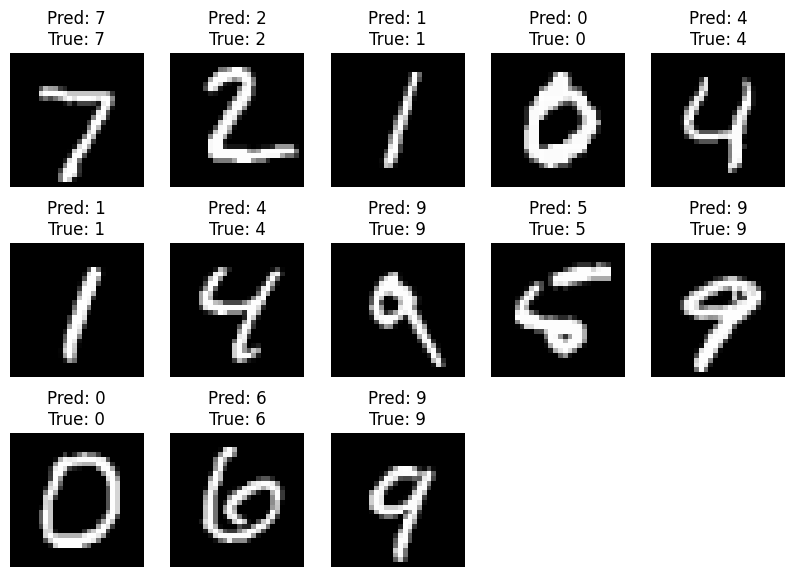

In [142]:
plot_predictions(X_test, y_test, y_pred_nn, n_images=13)

### Model Convolutional Neural Network

In [143]:
model_cnn = MnistClassifier(algorithm="cnn")

In [144]:
# Training
model_cnn.train(X_train, y_train)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8866 - loss: 0.3830
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9845 - loss: 0.0488
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9906 - loss: 0.0301
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9933 - loss: 0.0208
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9939 - loss: 0.0183
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9960 - loss: 0.0120
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9964 - loss: 0.0112
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9975 - loss: 0.0083
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9966 - loss: 0.0099
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9981 - loss: 0.0064
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9978 - loss: 0.0064
Epoch 12/15
469/469 ━━━━━━━━━━━━━

In [145]:
# Prediction
y_pred_cnn = model_cnn.predict(X_test)
print(
    f"Classification report for the model:\n",
    classification_report(y_test, y_pred_cnn),
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification report for the model:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [146]:
# Size evaluation
model_size_evaluation(model_cnn)

Model size in memory: 10908614 B (10652.94 kB / 10.40 MB)


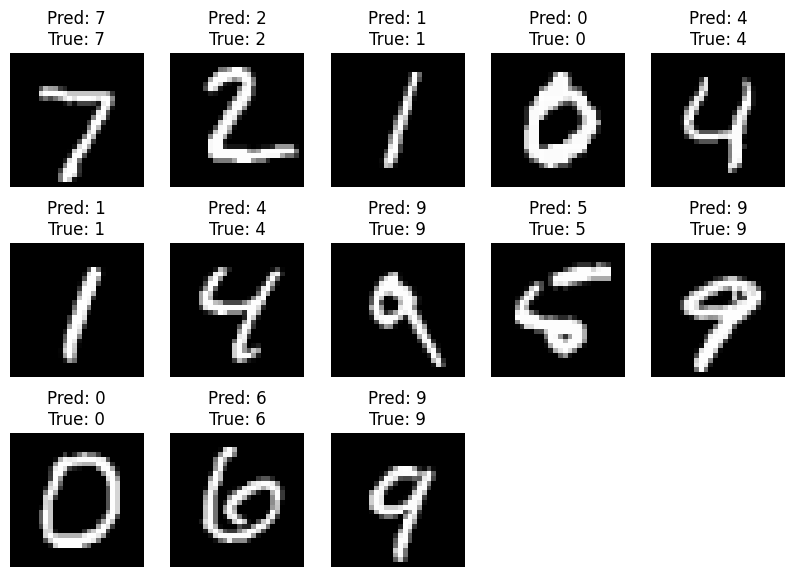

In [147]:
plot_predictions(X_test, y_test, y_pred_cnn, n_images=13)

### Another Model

In [148]:
error_message = None
try:
    model_another = MnistClassifier(algorithm="another")
except ValueError as e:
    error_message = str(e)

# Checking if there was an error.
if error_message:
    print(f"An error occurred: {error_message}")

An error occurred: Invalid algorithm. Choose from: 'rf', 'nn', 'cnn'.


In [149]:
joblib.dump(model_rf, "model_rf.joblib")
joblib.dump(model_nn, "model_nn.joblib")
joblib.dump(model_cnn, "model_cnn.joblib")

['model_cnn.joblib']